In [44]:
import tensorflow as tf
from sklearn.preprocessing import OneHotEncoder
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping
import pandas as pd
from sklearn.datasets import load_diabetes
from sklearn.preprocessing import StandardScaler
import random

import sys
sys.path.append('/Users/sebastianjara/Documents/Reu jueves uv/18_Julio_v2/')
from Core.data_selector import DataSelector

import matplotlib.pyplot as plt

In [45]:
# Fijar semillas
np.random.seed(41)
tf.random.set_seed(41)
random.seed(41)

# 1. Diabetes dataset


In [46]:
# Load data
data = load_diabetes()
X, y = data.data, data.target

# Convert labels to categorical format (binary classification: >140 diabetes, <=140 no diabetes)
y = (y > 140).astype(int)

### Applying SelectKBest

In [47]:
from sklearn.feature_selection import SelectKBest, f_classif

# Select the k best features
k = 3  # Number of features to select
selector = SelectKBest(score_func=f_classif, k=k)
X_new = selector.fit_transform(X, y)

# Selected features
selected_features = selector.get_support(indices=True)
print("Indices of the selected features:", selected_features)
print("Selected features:", [data.feature_names[i] for i in selected_features])


Indices of the selected features: [2 3 8]
Selected features: ['bmi', 'bp', 's5']


In [48]:
# Normalize the features
scaler = StandardScaler()
X = scaler.fit_transform(X_new)

# Split into train and test
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# OneHot encoding
enc = OneHotEncoder(sparse_output=False)
y_train_encoded = enc.fit_transform(y_train.reshape(-1, 1))
y_val_encoded = enc.transform(y_val.reshape(-1, 1))

print("Shape of X_train:", X_train.shape)
print("Shape of y_train:", y_train_encoded.shape)
print("Shape of X_test:", X_val.shape)
print("Shape of y_test:", y_val_encoded.shape)

Shape of X_train: (353, 3)
Shape of y_train: (353, 2)
Shape of X_test: (89, 3)
Shape of y_test: (89, 2)


## 2. Model

In [49]:
# Create the model
class CustomModel(tf.keras.Model):
    def __init__(self, D_in, H1, H2, H3, D_out):
        super(CustomModel, self).__init__()
        self.cl1 = tf.keras.layers.Dense(H1, activation='relu', input_shape=(D_in,))
        self.cl2 = tf.keras.layers.Dense(H1, activation='relu')
        self.cl3 = tf.keras.layers.Dense(H2, activation='relu')
        self.cl4 = tf.keras.layers.Dense(H3, activation='relu')
        self.fc1 = tf.keras.layers.Dense(D_out, activation='softmax')

    def call(self, inputs):
        x = self.cl1(inputs)
        x = self.cl2(x)
        x = self.cl3(x)
        x = self.cl4(x)
        x = self.fc1(x)
        return x

    def inspector_out(self, inputs):
        x = self.cl1(inputs)
        x = self.cl2(x)
        x = self.cl3(x)  
        return x
    

In [50]:
# Instantiate the model
model_dia = CustomModel(10, 30, 30, 30, 2)

## 3. First training phase: without filtering

In [51]:
# Training configuration
learning_rate = 0.001
adam_optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=learning_rate)
model_dia.compile(optimizer=adam_optimizer, loss='binary_crossentropy', metrics=['accuracy'])

# Early Stopping
early_stopping = EarlyStopping(monitor='val_accuracy',      
                               patience=20,                 
                               verbose=1,                  
                               mode='max',                  
                               restore_best_weights=True)   

# Training
model_dia.fit(X_train, y_train_encoded, epochs=3000, batch_size=100, verbose = 0, validation_data=(X_val, y_val_encoded), callbacks=[early_stopping])

2024-07-18 08:50:47.761428: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-07-18 08:50:48.169108: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


Restoring model weights from the end of the best epoch: 4.
Epoch 24: early stopping


### Results

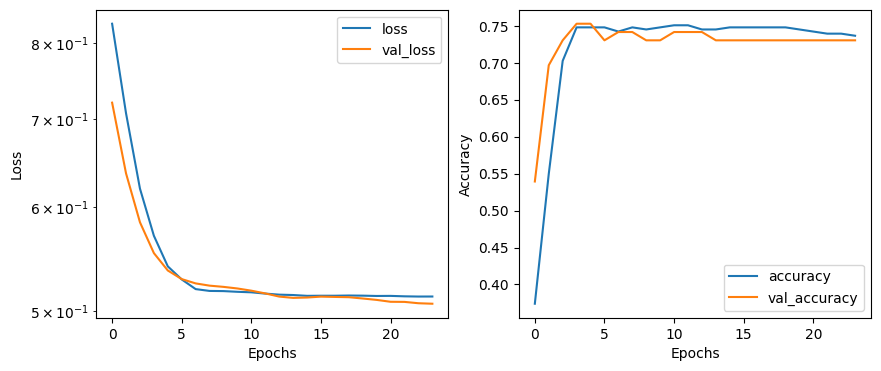

In [52]:
# Loss function graph and accuracy graph
plt.figure(figsize=(10, 4))

# Loss graph
plt.subplot(1, 2, 1)
plt.plot(model_dia.history.history['loss'], label='loss')
plt.plot(model_dia.history.history['val_loss'], label='val_loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.yscale('log')
plt.legend()

# Accuracy graph 
plt.subplot(1, 2, 2)
plt.plot(model_dia.history.history['accuracy'], label='accuracy')
plt.plot(model_dia.history.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()


In [53]:
# Evaluation for the best weights for the model
loss_train, accuracy_train = model_dia.evaluate(X_train, y_train_encoded, verbose=0)
loss_val, accuracy_val = model_dia.evaluate(X_val, y_val_encoded, verbose=0)
print(f"Train loss: {loss_train}")
print(f"Train accuracy: {accuracy_train}")
print(f"Validation loss: {loss_val}")
print(f"Validation accuracy: {accuracy_val}")

Train loss: 0.5483396649360657
Train accuracy: 0.7393767833709717
Validation loss: 0.5531794428825378
Validation accuracy: 0.7528089880943298


## 4. Second training phase: with filtering

In [54]:
epochs = 20                    # Number of epochs
epoch_init_filter = 1          # Epoch at which the filter starts
update_period_in_epochs = 5    # Update period in epochs

In [55]:
# Instantiate data selector
data_selector = DataSelector(X_train, y_train_encoded, epoch_init_filter , update_period_in_epochs, filter_percentile=0.15, random_state=280296, train_with_outliers=False)

In [56]:
from tensorflow.keras.callbacks import ModelCheckpoint

# Set up the callback to save the best weights
checkpoint_filepath = 'model_checkpoint_2.weights.h5'
model_checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True,
    verbose=0)

In [57]:
# Dictionary to store the training information
train_info = {
    'train_losses': [],
    'val_losses': [],
    'train_accuracies': [],
    'val_accuracies': []
}

# Training loop
for epoch in range(epochs):
    # Get filtered training sets
    X_tr_filtered, y_tr_filtered, _, x_index_filter = data_selector.get_train_data(epoch=epoch, model=model_dia, outs_posibilities=list(np.unique(y_train)), explained_variance = 0.95)
    
    # Fit the model
    history = model_dia.fit(X_tr_filtered, y_tr_filtered, epochs=1, batch_size=100, verbose=0, validation_data=(X_val, y_val_encoded), callbacks=[model_checkpoint_callback] )
    
    # Store the training information
    train_info['train_losses'].append(history.history['loss'])
    train_info['val_losses'].append(history.history['val_loss'])
    train_info['train_accuracies'].append(history.history['accuracy'])
    train_info['val_accuracies'].append(history.history['val_accuracy'])

    print(f"Epoch: {epoch+1}")

Epoch: 1
PCA done: retained 95.0% of the variance with 6 components
PCA done with 6 components
Size of the training set: 353
All classes have just one cluster associated
Number of probabilities below the threshold 0.0 for the actual class 0:  0
Number of probabilities below the threshold 0.05 for the actual class 1:  27
Remove data: [  1 260 133 134 152 154 155 158 165 167 296 300 174 316 320 197 327 202
 210  83 213 217 219 350 234 237 123]
Data has been filtered
Size of data removed: 27


2024-07-18 08:50:50.027046: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


Epoch: 2
Epoch: 3
Epoch: 4
Epoch: 5
Epoch: 6
PCA done: retained 95.0% of the variance with 5 components
PCA done with 5 components
Size of the training set: 326
All classes have just one cluster associated
Number of probabilities below the threshold 0.0 for the actual class 0:  0
Number of probabilities below the threshold 1.0 for the actual class 1:  4
Remove data: [170 318  48  67]
Data has been filtered
Size of data removed: 4
Epoch: 7
Epoch: 8
Epoch: 9
Epoch: 10
Epoch: 11
PCA done: retained 95.0% of the variance with 4 components
PCA done with 4 components
Size of the training set: 322
All classes have just one cluster associated
Number of probabilities below the threshold 0.0 for the actual class 0:  0
Number of probabilities below the threshold 1.0 for the actual class 1:  5
Remove data: [189  57  74 312  26]
Data has been filtered
Size of data removed: 5
Epoch: 12
Epoch: 13
Epoch: 14
Epoch: 15
Epoch: 16
PCA done: retained 95.0% of the variance with 4 components
PCA done with 4 c

In [58]:
print(f'Initial sets training: {X_train.shape[0]}')
print(f'Final sets training: {X_tr_filtered.shape[0]}')


Initial sets training: 353
Final sets training: 317


### Results

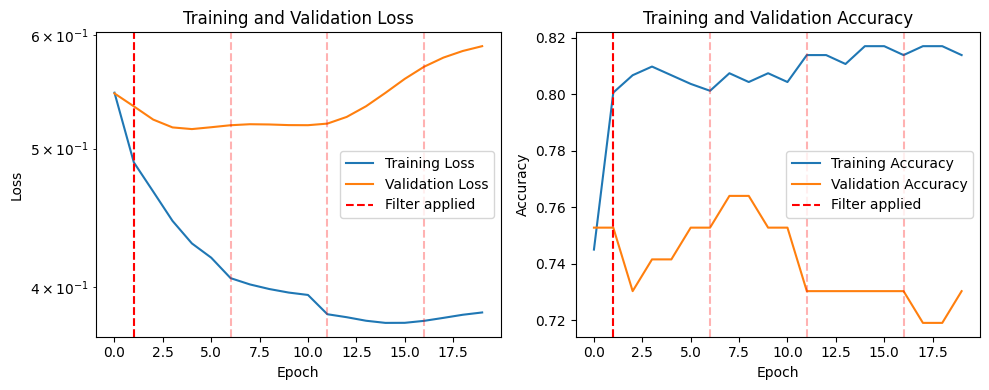

In [59]:
# Plot training and validation lossn
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(train_info['train_losses'], label='Training Loss')
plt.plot(train_info['val_losses'], label='Validation Loss')
plt.axvline(x=epoch_init_filter, color='r', linestyle='--', label='Filter applied')
for i in range(epoch_init_filter, epochs + 1, update_period_in_epochs):
    plt.axvline(x=i, color='r', linestyle='--', alpha=0.3)  
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.yscale('log')
plt.ylabel('Loss')
plt.legend()

# Plot training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(train_info['train_accuracies'], label='Training Accuracy')
plt.plot(train_info['val_accuracies'], label='Validation Accuracy')
plt.axvline(x=epoch_init_filter, color='r', linestyle='--', label='Filter applied')
for i in range(epoch_init_filter, epochs + 1, update_period_in_epochs):
    plt.axvline(x=i, color='r', linestyle='--', alpha=0.3)  
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [60]:
# Load best weights
model_dia.load_weights(checkpoint_filepath)

# Evaluation Accuracy
loss_train, accuracy_train = model_dia.evaluate(X_tr_filtered, y_tr_filtered, verbose=0)
loss_val, accuracy_val = model_dia.evaluate(X_val, y_val_encoded, verbose=0)
print(f"Training loss: {loss_train}")
print(f"Training accuracy: {accuracy_train}")
print(f"Validation loss: {loss_val}")
print(f"Validation accuracy: {accuracy_val}")

2024-07-18 08:50:53.173278: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


Training loss: 0.3884904086589813
Training accuracy: 0.8170347213745117
Validation loss: 0.5199772119522095
Validation accuracy: 0.7640449404716492


## 5. Outliers Visualization

### Visualization with two PCA components

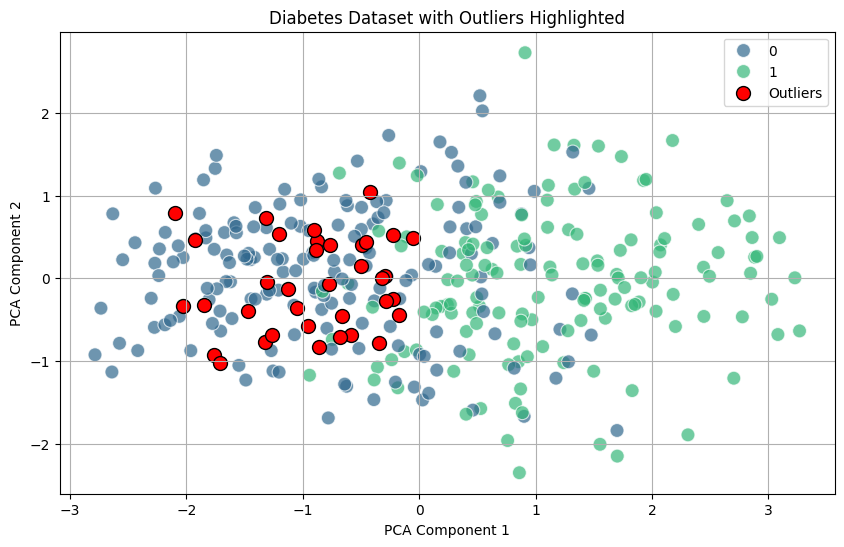

In [61]:
from sklearn.decomposition import PCA
import seaborn as sns

# Apply PCA to reduce dimensionality to 2 components for visualization
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_train)

# DataFrame with the transformed data and labels
df_pca = pd.DataFrame(X_pca, columns=['PCA1', 'PCA2'])
df_pca['class'] = y_train_encoded.argmax(axis=1)

# Scatter plot of the original dataset
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df_pca, x='PCA1', y='PCA2', hue='class', palette='viridis', s=100, alpha=0.7)

# Highlight the points that were filtered (detected outliers)
plt.scatter(X_pca[x_index_filter, 0], X_pca[x_index_filter, 1], color='red', s=100, label='Outliers', edgecolor='black')

plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.title('Diabetes Dataset with Outliers Highlighted')
plt.legend()
plt.grid(True)


plt.show()

### Visualization with three PCA components

In [62]:
import plotly.express as px
import plotly.graph_objects as go

# Apply PCA to reduce dimensionality to 3 components for visualization
pca = PCA(n_components=3)
X_pca = pca.fit_transform(X_train)

# DataFrame with the transformed data and labels
df_pca = pd.DataFrame(X_pca, columns=['PCA1', 'PCA2', 'PCA3'])
df_pca['class'] = y_train
df_pca['outlier'] = 'Normal'
df_pca.loc[x_index_filter, 'outlier'] = 'Outlier'

# Scatter plot of the original dataset
fig = px.scatter_3d(df_pca, x='PCA1', y='PCA2', z='PCA3', color='class',
                    title='PCA of Diabetes Dataset',
                    labels={'class': 'Diabetes'},
                    opacity=0.7)

# Highlight the points that were filtered (detected outliers)
fig.add_trace(go.Scatter3d(
    x=df_pca.loc[df_pca['outlier'] == 'Outlier', 'PCA1'],
    y=df_pca.loc[df_pca['outlier'] == 'Outlier', 'PCA2'],
    z=df_pca.loc[df_pca['outlier'] == 'Outlier', 'PCA3'],
    mode='markers',
    marker=dict(size=5, color='red'),
    name='Outliers'
))

# Update the chart design
fig.update_layout(scene=dict(
    xaxis_title='PCA Component 1',
    yaxis_title='PCA Component 2',
    zaxis_title='PCA Component 3'),
    margin=dict(l=0, r=0, b=0, t=40),
    legend=dict(
        x=0,
        y=1,
        traceorder="normal",
        font=dict(
            family="sans-serif",
            size=12,
            color="black"
        ),
        bgcolor="LightSteelBlue",
        bordercolor="Black",
        borderwidth=2
    )
)

fig.show()